**Libraries used**

In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.io as io
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader,random_split
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import f1_score, precision_score, recall_score


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define video transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize frames
    transforms.RandomHorizontalFlip(),  # Random horizontal flip for augmentation
    transforms.ToTensor(),          # Convert frames to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize Image Net
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize frames
    transforms.ToTensor(),          # Convert frames to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Preprocess video function
def preprocess_video(video_path, num_frames=16, transform=None):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate frame selection interval
    interval = frame_count // num_frames if frame_count >= num_frames else 1

    # Extract frames
    for i in range(0, frame_count, interval):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB
        frame = Image.fromarray(frame)  # Convert to PIL image
        frames.append(frame)

    cap.release()

    # If not enough frames, pad with the last frame
    while len(frames) < num_frames:
        frames.append(frames[-1])

    # Apply transformations
    frames = [transform(frame) for frame in frames] if transform else frames
    video_tensor = torch.stack(frames)  # Stack frames into tensor
    video_tensor = video_tensor.permute(1, 0, 2, 3)  # Change to (C, T, H, W)

    return video_tensor
# Function to preprocess video with frame skipping
def preprocess_video_with_frame_skip(video_path, num_frames=16, frame_skip=10, transform=None):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Iterate over frames, skipping based on frame_skip interval
    for i in range(0, frame_count, frame_skip):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to RGB (OpenCV loads frames as BGR by default)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Convert the frame to a PIL image and apply transforms (if any)
        frame = Image.fromarray(frame)
        if transform:
            frame = transform(frame)

        frames.append(frame)

        # Stop once we have the required number of frames
        if len(frames) >= num_frames:
            break

    cap.release()

    # If not enough frames, pad with the last frame
    while len(frames) < num_frames:
        frames.append(frames[-1])

    # Stack frames into a single tensor and adjust the shape
    video_tensor = torch.stack(frames)  # Shape: (num_frames, C, H, W)
    video_tensor = video_tensor.permute(1, 0, 2, 3)  # Shape: (C, T, H, W)

    return video_tensor
# Custom Video Dataset class
class VideoDataset(Dataset):
    def __init__(self, root_dir, num_frames=16, transform=None):
        self.video_paths, self.labels = self.get_video_paths_and_labels(root_dir)
        self.num_frames = num_frames
        self.transform = transform

    def get_video_paths_and_labels(self, root_dir):
        video_paths = []
        labels = []
        for class_dir in ['shop lifters', 'non shop lifters']:
            class_path = os.path.join(root_dir, class_dir)
            label = 1 if class_dir == 'shop lifters' else 0  # Correct label assignment
            for video_name in os.listdir(class_path):
                video_paths.append(os.path.join(class_path, video_name))
                labels.append(label)
        return video_paths, labels

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        video = preprocess_video_with_frame_skip(video_path, num_frames=self.num_frames, transform=self.transform)
        return video, label


# Use the function to list all videos
root_directory = '/content/drive/MyDrive/datasets/Shop DataSet'  # Base directory where the 'shoplifters' and 'non-shoplifters' folders are

# Create dataset and split into train, validation, and test sets
dataset = VideoDataset(root_directory, transform=None)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size


In [4]:
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Apply transformations separately for train and test sets
train_set.dataset.transform = train_transforms
val_set.dataset.transform = test_transforms
test_set.dataset.transform = test_transforms
# Create data loaders
batch_size = 1
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


#Visualize


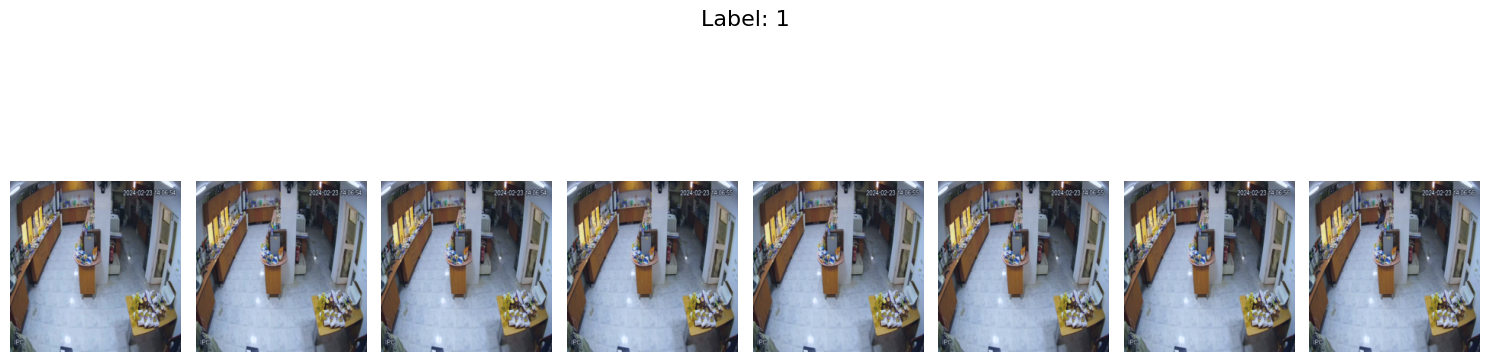

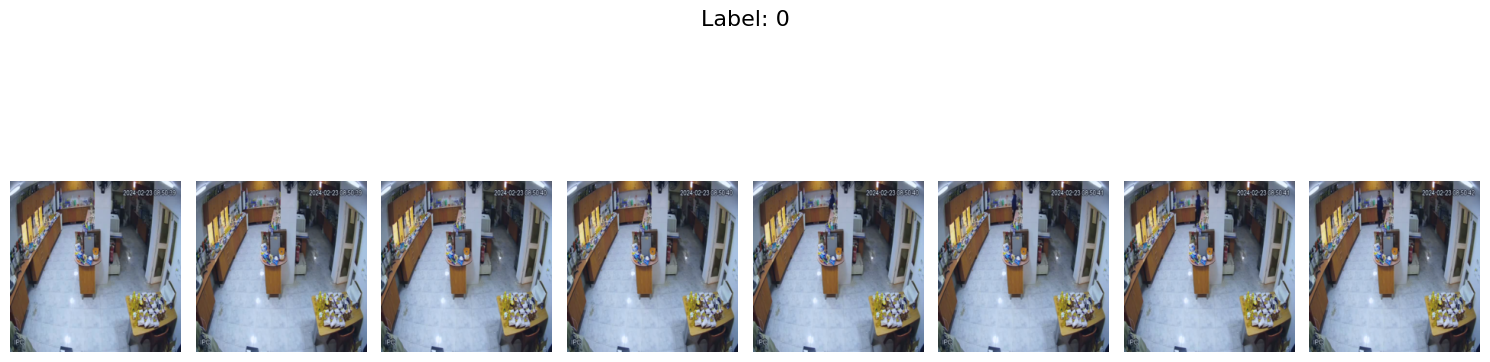

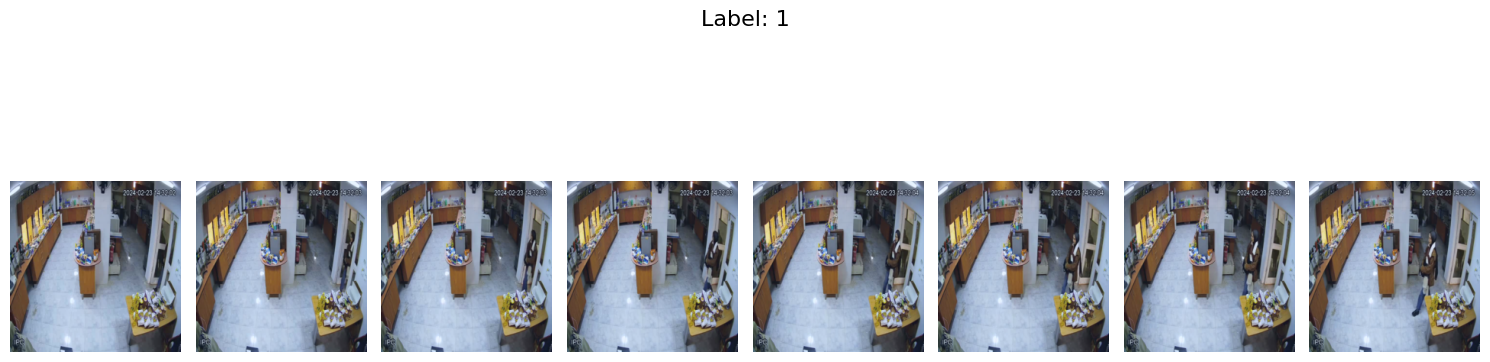

In [5]:
# Visualize a few frames from the training set
def show_sample_frames(loader, num_samples=3, num_frames=5):
    for i, (video, label) in enumerate(loader):
        if i >= num_samples:
            break
        video = video.squeeze(0)  # Remove batch dimension
        label = label.item()

        plt.figure(figsize=(15, 5))
        plt.suptitle(f'Label: {label}', fontsize=16)

        for j in range(min(num_frames, video.size(1))):  # Loop over frames (T dimension)
            plt.subplot(1, num_frames, j + 1)
            frame = video[:, j].permute(1, 2, 0).cpu().numpy()  # (C, H, W) -> (H, W, C)
            frame = (frame * 0.229 + 0.485).clip(0, 1)  # Denormalize for display
            plt.imshow(frame)
            plt.axis('off')

        plt.tight_layout()
        plt.show()


# Show some sample frames
show_sample_frames(train_loader, num_samples=3, num_frames=8)

**Model Architeture**

In [6]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
# Load the X-CLIP model and processor
processor = VideoMAEImageProcessor.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics", torch_dtype=torch.float16)
model = VideoMAEForVideoClassification.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")

#model.config.num_labels = 2  # Binary classification
#model.classifier = nn.Linear(in_features=768, out_features=1)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

# Training

In [ ]:
from transformers import AdamW

# set up limits
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = " max_split_size_mb:516" #expandable_segments:True

# Optimizer

#torch.cuda.reset_max_memory_cached()
# Set up your device, model, loss function, optimizer, and data loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scaler=torch.GradScaler(device, )
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = AdamW(model.parameters(), lr=0.0001)

num_epochs = 10   # Set your number of epochs
accumulation_steps=4
# Training loop
##
for epoch in range(num_epochs):
    model.train()  # Training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_train_preds = []
    all_train_labels = []
    optimizer.zero_grad(set_to_none=True)  # Save memory

    for i, (videos, labels) in enumerate(train_loader):
        videos = videos.to(device)
        labels = labels.to(device).float()#.unsqueeze(1)  # Shape [batch_size, 1] for BCE loss
        video_tensor = videos.permute(0, 2, 1, 3, 4)  # [batch, channels, frames, height, width]
        #video_tensor = video_tensor.squeeze(0) # Remove batch dimension
        print(f"Video tensor sequence: {i}")  # Check input shape

        #PREprocess the videos into the proper shape of the model
        #inputs = processor(video_tensor, return_tensors="pt")

        #inputs = processor(
        #        text=["Shop lifter", "non shop lifter"],
        #        videos=video_tensor[:, :, :, :, 2], #PASS one channel from Data loader
        #        return_tensors="pt",
        #        padding=True,
        #        )#.to(device)

        if torch.cuda.is_available():
          with torch.autocast('cuda'):
               # Forward pass
                outputs = model(video_tensor)
                #logits_per_video = outputs.logits
                logits_per_video = torch.mean(outputs.logits, dim=1)  # Aggregate over the 400 outputs
                loss = criterion(logits_per_video, labels)
        else:
          with torch.autocast('cpu'):
               # Forward pass
                outputs = model(video_tensor)
                #logits_per_video = outputs.logits
                logits_per_video = torch.mean(outputs.logits, dim=1)  # Aggregate over the 400 outputs
                loss = criterion(logits_per_video, labels)

        # Scale loss and backward pass
        scaler.scale(loss).backward()

        # Gradient accumulation
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)  # Zero out gradients for the next step

        # Accumulate loss
        running_loss += loss.item()
        # Predictions for training accuracy
        preds = torch.sigmoid(logits_per_video).round()  # Convert logits to probabilities and round
        all_train_preds.extend(preds.cpu().detach().to(torch.float32).numpy())  # Collect predictions
        all_train_labels.extend(labels.cpu().detach().to(torch.float32).numpy())  # Collect true labels

        # Calculate training accuracy
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        # Clear CUDA cache periodically
        if (i + 1) % accumulation_steps == 0:
            torch.cuda.empty_cache()

    # Calculate training metrics
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_train / total_train
    train_f1 = f1_score(all_train_labels, all_train_preds)
    train_precision = precision_score(all_train_labels, all_train_preds)
    train_recall = recall_score(all_train_labels, all_train_preds)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for videos, labels in val_loader:
            videos = videos.to(device)
            labels = labels.to(device).float()#.unsqueeze(1)  # Shape [batch_size, 1]
            video_tensor = videos.permute(0, 2, 1, 3, 4)  # [batch, channels, frames, height, width]

            if torch.cuda.is_available():
                with torch.autocast('cuda'):
                  # Forward pass
                   outputs = model(video_tensor)
                   #logits_per_video = outputs.logits
                   logits_per_video = torch.mean(outputs.logits, dim=1)#.unsqueeze(1)  # Aggregate over the 400 outputs
                   loss = criterion(logits_per_video, labels)
            else:
                with torch.autocast('cpu'):
               # Forward pass
                   outputs = model(video_tensor)
                   #logits_per_video = outputs.logits
                   logits_per_video = torch.mean(outputs.logits, dim=1)#.unsqueeze(1)
                   loss = criterion(logits_per_video, labels)

            # Accumulate validation loss
            val_loss += loss.item()
            # Calculate validation predictions and accumulate them
            preds = torch.sigmoid(logits_per_video).round()  # Convert logits to probabilities and round
            all_val_preds.extend(preds.cpu().detach().to(torch.float32).numpy())  # Collect predictions
            all_val_labels.extend(labels.cpu().detach().to(torch.float32).numpy())  # Collect true labels

            # Calculate validation accuracy
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

            # Clear CUDA cache during validation to prevent memory buildup
            if (i + 1) % accumulation_steps == 0:
                torch.cuda.empty_cache()
    # Calculate average loss and accuracy for the validation set
    val_loss = val_loss / len(val_loader)
    val_acc = correct_val / total_val
    # Calculate precision, recall, and F1-score for validation
    val_f1 = f1_score(all_val_labels, all_val_preds)
    val_precision = precision_score(all_val_labels, all_val_preds)
    val_recall = recall_score(all_val_labels, all_val_preds)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

    # Free any remaining cache after the epoch
    torch.cuda.empty_cache()

# Training and validation loop
"""
for epoch in range(num_epochs):
    model.train()  # Training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for videos, labels in train_loader:
        videos = videos.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # Shape [batch_size, 1] for BCE loss
        video_tensor = videos.permute(0, 2, 1, 3, 4).to(device)  # [batch, channels, frames, height, width]

        optimizer.zero_grad(set_to_none=True)

        # Use automatic mixed precision
        if torch.cuda.is_available():
          with torch.autocast('cuda'):
               # Forward pass
               outputs = model(video_tensor)
               loss = criterion(outputs, labels)
        else:
          with torch.autocast('cpu'):
               # Forward pass
               outputs = model(video_tensor)
               loss = criterion(outputs, labels)

        # Scale the loss and backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate loss
        running_loss += loss.item()

        # Calculate training accuracy
        preds = torch.sigmoid(outputs).round()  # Convert logits to probabilities and round
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    # Calculate average loss and accuracy for the training epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_train / total_train

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for videos, labels in val_loader:
            videos = videos.to(device)
            labels = labels.to(device).float().unsqueeze(1)  # Shape [batch_size, 1]

            with torch.autocast(device):
                outputs = model(videos)
            # Use automatic mixed precision
            if torch.cuda.is_available():
               with torch.autocast('cuda'):
                 # Forward pass
                  outputs = model(video_tensor)
                  loss = criterion(outputs, labels)
            else:
               with torch.autocast('cpu'):
                 # Forward pass
                  outputs = model(video_tensor)
                  loss = criterion(outputs, labels)

            # Accumulate validation loss
            val_loss += loss.item()

            # Calculate validation accuracy
            preds = torch.sigmoid(outputs).round()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    # Calculate average loss and accuracy for the validation set
    val_loss = val_loss / len(val_loader)
    val_acc = correct_val / total_val

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    torch.cuda.empty_cache()
"""
print("Training complete.")


Video tensor sequence: 0


***Evaluation***

In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_test_preds = []
    all_test_labels = []

    criterion = nn.BCEWithLogitsLoss()  # The same loss function used in training

    with torch.no_grad():
        for videos, labels in test_loader:
            videos = videos.to(device)
            labels = labels.to(device).float()

            if torch.cuda.is_available():
                with torch.cuda.amp.autocast():
                    # Forward pass
                    outputs = model(videos.permute(0, 2, 1, 3, 4))  # Reshape the tensor if needed
                    logits_per_video = torch.mean(outputs.logits, dim=1)#.unsqueeze(1)
                    loss = criterion(logits_per_video, labels)
            else:
                # Forward pass for CPU
                outputs = model(videos.permute(0, 2, 1, 3, 4))  # Reshape the tensor if needed
                logits_per_video = torch.mean(outputs.logits, dim=1)#.unsqueeze(1)
                loss = criterion(logits_per_video, labels)

            # Accumulate test loss
            test_loss += loss.item()

            # Predictions for test accuracy
            preds = torch.sigmoid(logits_per_video).round()  # Convert logits to probabilities and round
            all_test_preds.extend(preds.cpu().detach().numpy())  # Collect all predictions
            all_test_labels.extend(labels.cpu().detach().numpy())  # Collect all true labels

            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

            # Clear CUDA cache periodically to avoid memory overflow
            torch.cuda.empty_cache()

    # Calculate metrics for the test set
    test_loss = test_loss / len(test_loader)
    test_acc = correct_test / total_test
    test_f1 = f1_score(all_test_labels, all_test_preds)
    test_precision = precision_score(all_test_labels, all_test_preds)
    test_recall = recall_score(all_test_labels, all_test_preds)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

    return {
        "test_loss": test_loss,
        "test_acc": test_acc,
        "test_f1": test_f1,
        "test_precision": test_precision,
        "test_recall": test_recall
    }

# Example usage:
test_metrics = evaluate_model(model, test_loader, device)


In [ ]:
#def evaluate_model(model, dataloader):
#    model.eval()
#    correct = 0
#    total = 0
#
#    with torch.no_grad():
#        for videos, labels in dataloader:
#            videos, labels = videos.cuda(), labels.cuda()
#            outputs = model(videos)
#            _, predicted = torch.max(outputs, 1)
#            total += labels.size(0)
#            correct += (predicted == labels).sum().item()

#    accuracy = correct / total
#    print(f"Test Accuracy: {accuracy}")

#evaluate_model(model, test_loader)
